# Marked exercises after Lecture 10 on GANs

This notebook contains the marked exercises with instructions and explanations.

Work through the cells below in sequential order, executing each cell as you progress. Follow the instructions and write the code to complete the tasks. No code implementation is required in this notebook file. This notebook serves as the main file for the marked exercise and contains  the  code for initialising the models, initialising the dataset, setting the hyperparameters for training, and training the model. Throughout the exercise, you will encounter instructions marked with the words **YOUR CODE HERE** followed by **raise NotImplementedError()**. You will have to substitute  *raise NotImplementedError()* with your own code. 

Along the way, you may also find questions. Try to reflect on the questions before/after running the code.

**IMPORTANT NOTE**: You are **NOT ALLOWED** to change the code that we provide. All of the definitions of functions and all the hyperparameters should be kept as they are. You are NOT allowed to create new functions and you are ONLY allowed to write your code wherever you see *raise NotImplementedError()*. 

This notebook was developed at the [Idiap Research Institute](https://www.idiap.ch) by [Alina Elena Baia](mailto:alina.baia.idiap.ch>), [Darya Baranouskaya](mailto:darya.baranouskaya.idiap.ch) and [Olena Hrynenko](mailto:olena.hrynenko.idiap.ch) (equal contribution).
<!--
SPDX-FileCopyrightText: Copyright (c) 2024 Idiap Research Institute <contact@idiap.ch>
SPDX-FileContributor: Alina Elena Baia <alina.baia.idiap.ch>
SPDX-FileContributor: Darya Baranouskaya <darya.baranouskaya.idiap.ch>
SPDX-FileContributor: Olena Hrynenko <olena.hrynenko.idiap.ch>
-->

You are asked to complete the following tasks related to completing the implementation of a GAN training function and training
WGAN [17 points]
 - 2.10.1 [2 points] Implement weight clamping in `trainer.py: def clamp_weights(self)`
 - 2.10.2 [5 points] Implement Discriminator update step in `trainer.py: def disc_step(self, z, real_images)`.
 - 2.10.3 [5 points] Implement Generator update step in `trainer.py: def gen_step(self)`.
 - 2.10.4 [5 points] Complete the call of `disc_step()` and `gen_step()` in `train_epoch()` in `trainer.py`. Train your WGAN for 8 epochs. Report the generated images.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from model import Generator, Discriminator, weights_init
from trainer import WGANTrainer

import getpass
import os
import random
import re
import tarfile
import time

torch.manual_seed(42)

#### Dataset

In [3]:
#For efficient usage of the hardware resources when running on JupyterHub EPFL,
# we will limit the number of threads. 
if getpass.getuser() == "jovyan":
    num_threads_limit = 4
elif re.search(f'^https://.*noto.*\.epfl\.ch$', os.environ.get("EXTERNAL_URL", "")) != None:
    num_threads_limit = 2
else:
    num_threads_limit = torch.get_num_threads()
print(f"Limiting the number of threads to {num_threads_limit}")
torch.set_num_threads(num_threads_limit)
print(f"PyTorch is using {torch.get_num_threads()} threads")

_ = torch.set_flush_denormal(True) # To avoid long training time on CPU

Limiting the number of threads to 2
PyTorch is using 2 threads


<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_360/1966964959.py:5: SyntaxWarning: invalid escape sequence '\.'
  elif re.search(f'^https://.*noto.*\.epfl\.ch$', os.environ.get("EXTERNAL_URL", "")) != None:


In [4]:
def load_fashion_mnist_dataset(batch_size):
    transforms_fashion_mnist = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])
    dataset = datasets.FashionMNIST(root='/EE559-shared/', train=True, download=False, transform=transforms_fashion_mnist)
    # For testing your implementation, we recommend using a subset of the dataset to save images more often,
    # although that would be reflected in the quality of the generated images
    from torch.utils.data import Subset
    dataset = Subset(dataset, range(40000))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

#### Train the model

Generator(
  (layers): Sequential(
    (0): GeneratorBlock(
      (deconv_block): Sequential(
        (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): GeneratorBlock(
      (deconv_block): Sequential(
        (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (2): GeneratorBlock(
      (deconv_block): Sequential(
        (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (3): GeneratorBlock(
      (deconv_block): Sequential(
        (0): ConvTranspose2d(256, 1, kernel_size=(4,

/home/Marked Exercises/final_markedexercise/WGAN/trainer.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.fixed_z_for_check = torch.load('fixed_20_z_for_check.pt').

Epoch 0/8: gen_loss 0.5121897348687581, disc_loss -0.5581376951515674


/opt/jlab-env/lib/python3.12/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/jlab-env/lib/python3.12/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


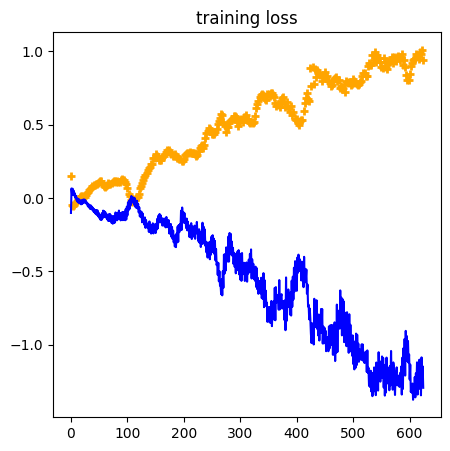

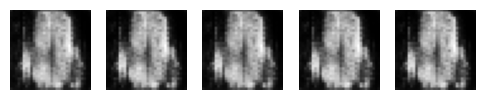

625it [00:29, 21.30it/s]


Epoch 1/8: gen_loss 0.8149529151493218, disc_loss -1.6449350313186646


<Figure size 2400x3000 with 0 Axes>

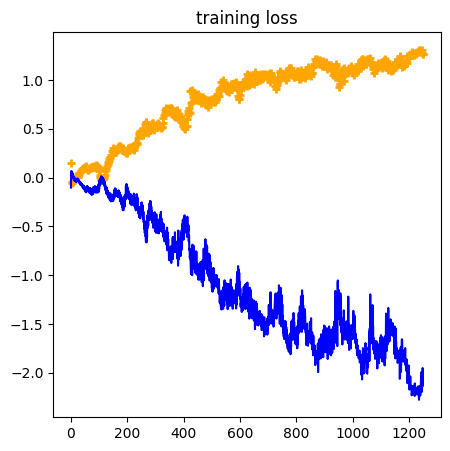

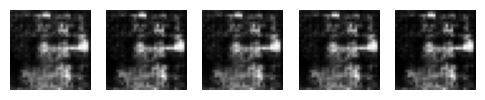

625it [00:29, 21.34it/s]


Epoch 2/8: gen_loss 1.0826961140155793, disc_loss -1.6596555533409119


<Figure size 2400x3000 with 0 Axes>

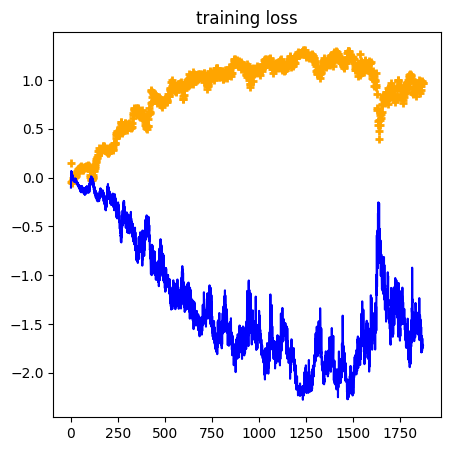

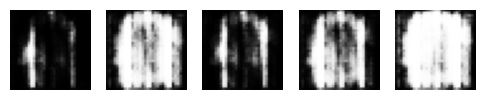

625it [00:29, 21.32it/s]


Epoch 3/8: gen_loss 1.0312852841854097, disc_loss -1.6542515474319457


<Figure size 2400x3000 with 0 Axes>

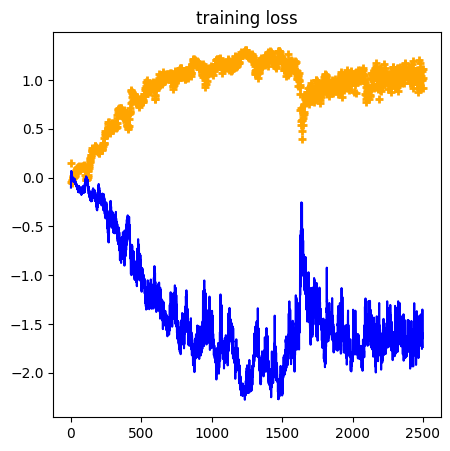

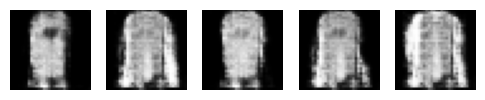

625it [00:29, 21.33it/s]


Epoch 4/8: gen_loss 0.9578854444503784, disc_loss -1.4341675785064698


<Figure size 2400x3000 with 0 Axes>

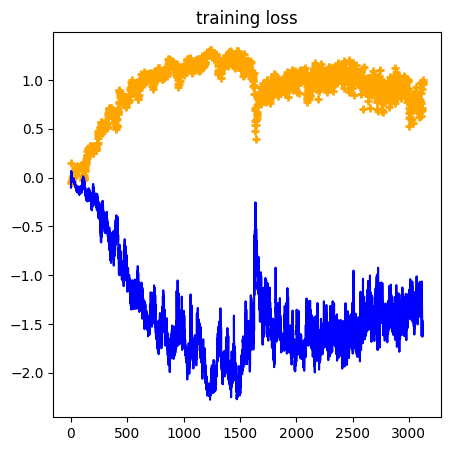

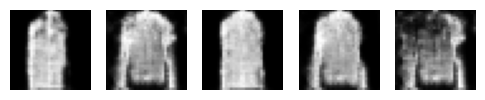

625it [00:29, 21.33it/s]


Epoch 5/8: gen_loss 0.8524039404869079, disc_loss -1.3581642666816711


<Figure size 2400x3000 with 0 Axes>

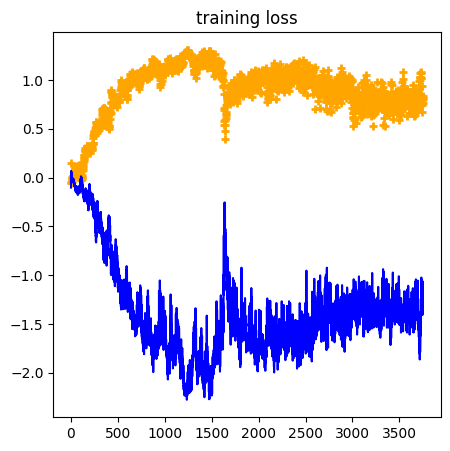

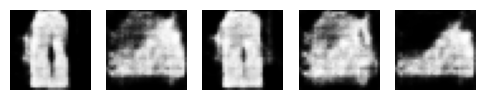

625it [00:29, 21.34it/s]


Epoch 6/8: gen_loss 0.7872736890792846, disc_loss -1.304809448814392


<Figure size 2400x3000 with 0 Axes>

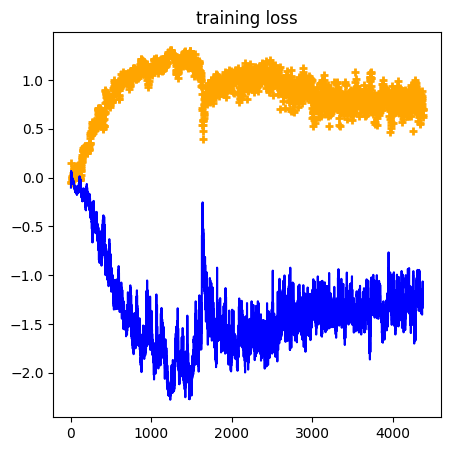

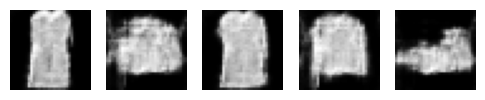

625it [00:29, 21.36it/s]


Epoch 7/8: gen_loss 0.7519110228538514, disc_loss -1.2373402536392213


<Figure size 2400x3000 with 0 Axes>

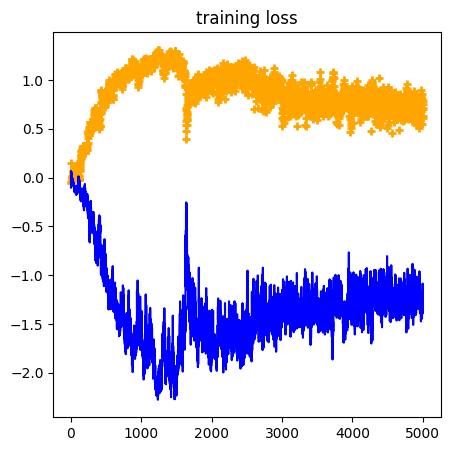

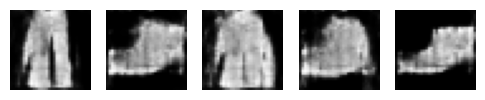

<Figure size 2400x3000 with 0 Axes>

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# You are NOT allowed to change hyperparameters
lr_gen = 0.00007
lr_disc = 0.00005
batch_size = 64
weight_cliping_limit = 0.01
n_critic_steps = 2
n_image_channels = 1  #3 if RGB and 1 if Greyscale

gen = Generator(in_channels=100, out_channels=n_image_channels)
disc = Discriminator(in_channels=n_image_channels)

print(gen.apply(weights_init))
print(disc.apply(weights_init))

gen.to(device)
disc.to(device)

# assert for you to check the correctness of the sizes of models outputs
z = torch.rand((4, 100, 1, 1), device=device)
fake_image = gen(z)
assert list(fake_image.shape) == [4, n_image_channels, 32, 32]
assert list(disc(fake_image).shape) == [4, 1, 1, 1]


# WGAN with gradient clipping uses RMSprop instead of ADAM
optimizer_gen = torch.optim.RMSprop(gen.parameters(), lr=lr_gen)
optimizer_disc = torch.optim.RMSprop(disc.parameters(), lr=lr_disc)

train_loader = load_fashion_mnist_dataset(batch_size)

#initialise the trainer
trainer = WGANTrainer(model_gen=gen, model_disc=disc,
                        optimizer_gen=optimizer_gen, optimizer_disc=optimizer_disc,
                        n_disc_steps=n_critic_steps, weight_cliping=weight_cliping_limit, device=device)

#train WGAN
trainer.train(n_epoches=8, train_loader=train_loader)
